In [76]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [77]:
#Time series analysis in Python
dataset = pd.read_csv('/Users/coding/Documents/GitHub/TimeSeriesAnalysisWithPython/data/AirPassengers.csv')
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])

In [78]:
indexedDataset

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


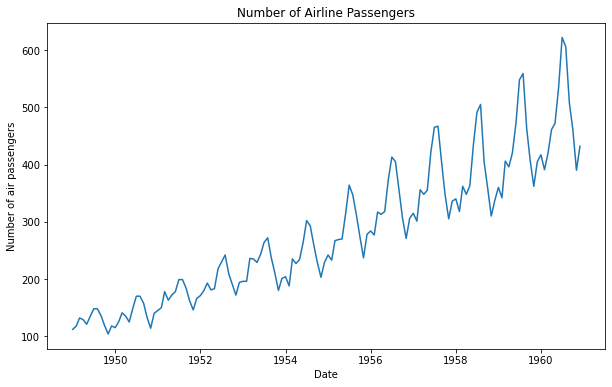

In [80]:
# Our data is not stationary as seen from the graph below. 
# Due to high growth in airline traffic, the mean is changing year over year.
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.title('Number of Airline Passengers')
plt.plot(indexedDataset)

In [81]:
rolmean = indexedDataset.rolling(window = 12).mean()
rolstd = indexedDataset.rolling(window = 12).std()

In [82]:
# The mean number of the airline passengers increases year over year
rolmean[12:]

,#Passengers
Month,
1950-01-01,126.916667
1950-02-01,127.583333
1950-03-01,128.333333
1950-04-01,128.833333
1950-05-01,129.166667
...,...
1960-08-01,463.333333
1960-09-01,467.083333
1960-10-01,471.583333


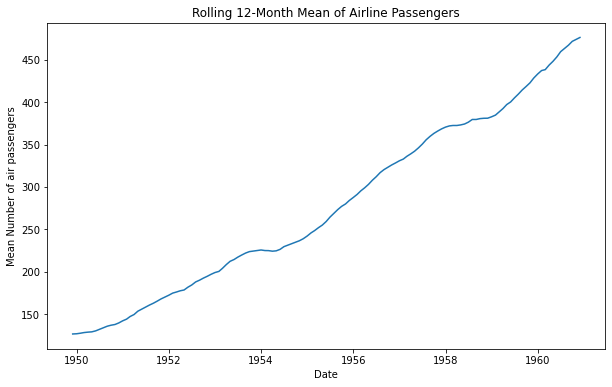

In [84]:
plt.xlabel('Date')
plt.ylabel('Mean Number of air passengers')
plt.title('Rolling 12-Month Mean of Airline Passengers')
plt.plot(rolmean)

In [85]:
# The standard deviation is also increasing over all over time and 
# fluctuates up and down between years. 
rolstd[12:]

,#Passengers
Month,
1950-01-01,13.453342
1950-02-01,13.166475
1950-03-01,13.686977
1950-04-01,13.822467
1950-05-01,13.663710
...,...
1960-08-01,83.630500
1960-09-01,84.617276
1960-10-01,82.541954


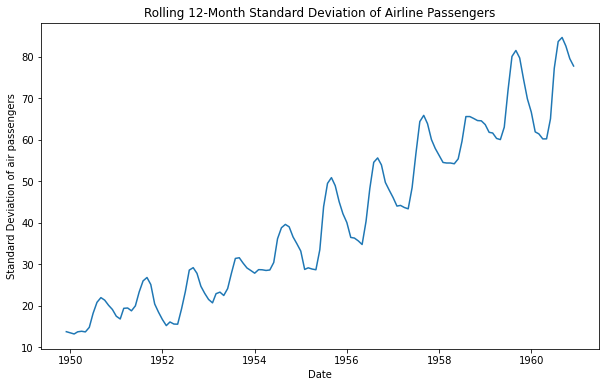

In [86]:
# As you can see, the standard deviation of air passengers increases overall 
# The standard deviation fluctuates between years in an up and down pattern.
plt.xlabel('Date')
plt.ylabel('Standard Deviation of air passengers')
plt.title('Rolling 12-Month Standard Deviation of Airline Passengers')
plt.plot(rolstd)

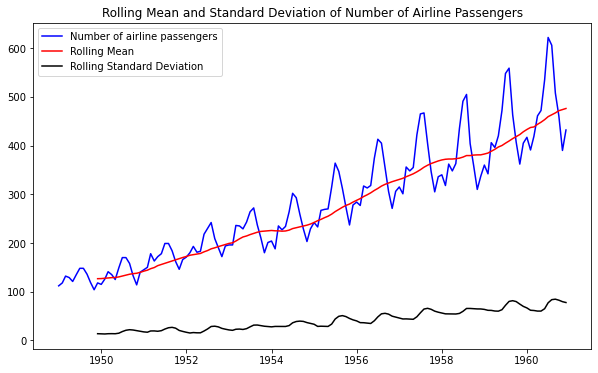

In [87]:
orig = plt.plot(indexedDataset, color = 'blue', label = 'Number of airline passengers')
mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation of Number of Airline Passengers')
plt.show(block=False)

In [88]:
Dickey_Fuller_Test = adfuller(indexedDataset['#Passengers'], autolag='AIC')
pd.Series(Dickey_Fuller_Test)

0                                             0.815369
1                                              0.99188
2                                                   13
3                                                  130
4    {'1%': -3.4816817173418295, '5%': -2.884041834...
5                                           996.692931
dtype: object

In [89]:
# The results of the Dickey Fuller Test show that the data is not stationary
Dickey_Fuller_Output = pd.Series(Dickey_Fuller_Test, index = 
          ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used', 'Test Statistics', 'Maximized Information Criterion'])

for key, value in Dickey_Fuller_Test[4].items():
    Dickey_Fuller_Output['Critical Value (%s)'%key] = value #Unpacking embeded critical value dictionary
    
Dickey_Fuller_Output = Dickey_Fuller_Output.drop('Test Statistics')
Dickey_Fuller_Output

Test Statistic                       0.815369
p-value                               0.99188
#Lags Used                                 13
Number of Observations Used               130
Maximized Information Criterion    996.692931
Critical Value (1%)                 -3.481682
Critical Value (5%)                 -2.884042
Critical Value (10%)                 -2.57877
dtype: object

In [90]:
#KPSS also shows that the data is not stationary.
#KPSS tests for stationarity around a deterministic trend
kpsstest = kpss(indexedDataset['#Passengers'], regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
kpss_output

Test Statistic           1.651312
p-value                  0.010000
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

Text(0.5, 1.0, 'Estimating Trend: The pattern has not changed')

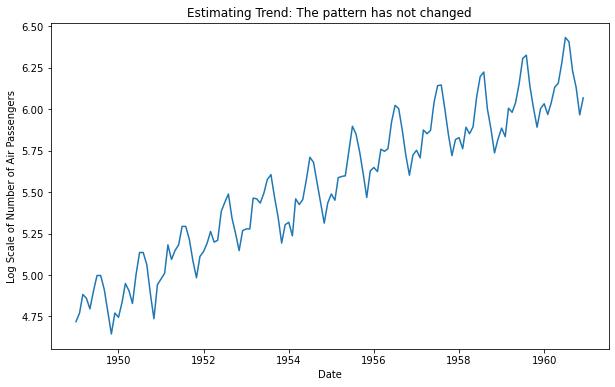

In [93]:
#Estimating Trend: The pattern has not changed
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)
plt.xlabel('Date')
plt.ylabel('Log Scale of Number of Air Passengers')
plt.title('Estimating Trend: The pattern has not changed')

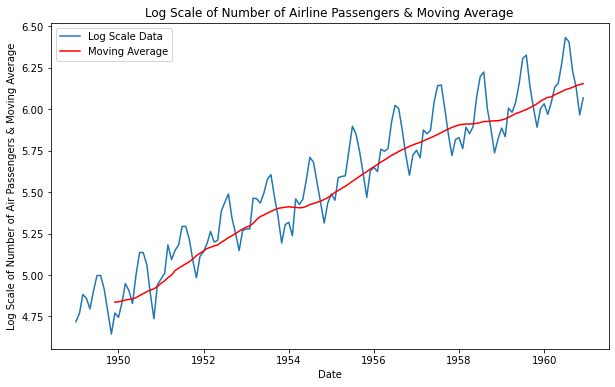

In [99]:
# The mean is still not stationary, however it is more stationary than before!
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingStd = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale, label='Log Scale Data')
plt.xlabel('Date')
plt.ylabel('Log Scale of Number of Air Passengers & Moving Average')
plt.plot(movingAverage, color='red', label = 'Moving Average')
plt.title('Log Scale of Number of Airline Passengers & Moving Average')
plt.legend()

In [100]:
# Make the time series stationary
LogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
LogScaleMinusMovingAverage.dropna(inplace=True)
LogScaleMinusMovingAverage.tail(10)

,#Passengers
Month,
1960-03-01,-0.036530
1960-04-01,0.046332
1960-05-01,0.060186
1960-06-01,0.175033
1960-07-01,0.315151
1960-08-01,0.282363
1960-09-01,0.098235
1960-10-01,-0.009230
1960-11-01,-0.182690


In [101]:
# Previously, I wanted to show each step in the process. 
# But, I can also put the code in functions like so.
# I will use these going forward to avoid repetitive code
 
def plot_stationarity(timeseries):
    movingAverage = timeseries.rolling(window=12).mean()
    movingStd = timeseries.rolling(window=12).std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Number of Airline Passengers')
    mean = plt.plot(movingAverage, color = 'red', label = 'Rolling Mean')
    std = plt.plot(movingStd, color = 'black', label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def test_stationarity(timeseries):
    Dickey_Fuller_Test = adfuller(timeseries['#Passengers'], autolag='AIC')

    Dickey_Fuller_Output = pd.Series(Dickey_Fuller_Test, index = 
          ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used', 'Test Statistics', 'Maximized Information Criterion'])

    for key, value in Dickey_Fuller_Test[4].items():
        Dickey_Fuller_Output['Critical Value (%s)'%key] = value #Unpacking embeded critical value dictionary

    Dickey_Fuller_Output = Dickey_Fuller_Output.drop('Test Statistics')
    return Dickey_Fuller_Output

def kpss_test(timeseries):
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    return kpss_output
    

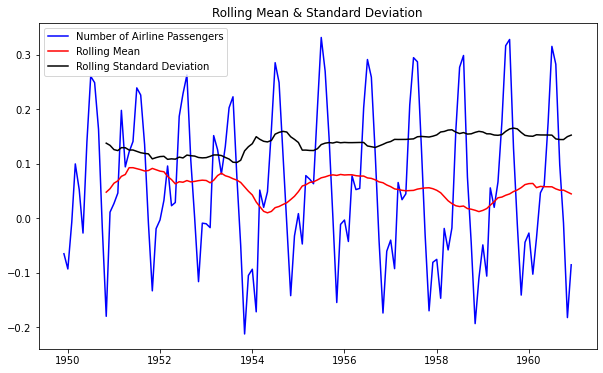

In [102]:
# Our data looks more stationary
plot_stationarity(LogScaleMinusMovingAverage)

In [103]:
#Augmented Dickey Fuller test
#Our p-value has decreased substantially. 
#We reject the null hypothesis that the data is non-stationary
test_stationarity(LogScaleMinusMovingAverage)

Test Statistic                      -3.162908
p-value                              0.022235
#Lags Used                                 13
Number of Observations Used               119
Maximized Information Criterion   -436.632695
Critical Value (1%)                 -3.486535
Critical Value (5%)                 -2.886151
Critical Value (10%)                -2.579896
dtype: object

In [104]:
#KPSS Test
#Cannot be used interchangeably with Dickey Fuller
#Tests for stationarity around a deterministic trend
kpss_test(LogScaleMinusMovingAverage)
#the data is basically stationary. We do not reject the null. 

Test Statistic           0.04306
p-value                  0.10000
#Lags Used               5.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64

#### Exponential Decay Weighted Average

Text(0.5, 1.0, 'Exponential Decay Weighted Average vs Log Scale Data')

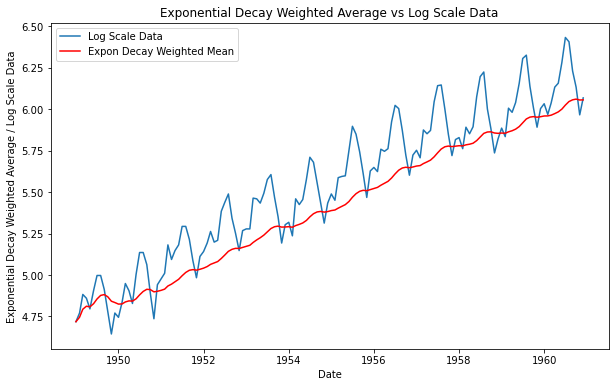

In [107]:
#Calculate the trend of the original time series
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife = 12, min_periods=0, adjust = True).mean()
plt.plot(indexedDataset_logScale, label='Log Scale Data')
plt.plot(exponentialDecayWeightedAverage, label='Expon Decay Weighted Mean', color='red')
plt.xlabel('Date')
plt.ylabel('Exponential Decay Weighted Average / Log Scale Data')
plt.legend()
plt.title('Exponential Decay Weighted Average vs Log Scale Data')

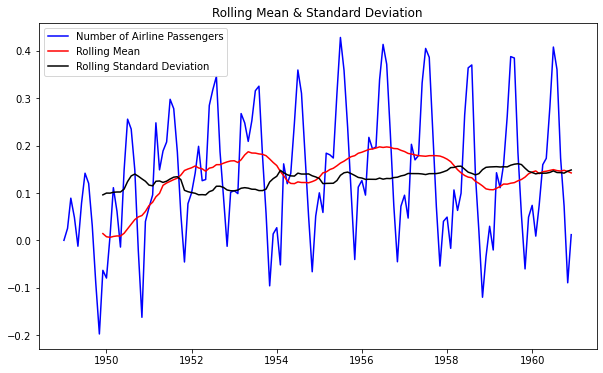

In [22]:
# Standard Deviation More Flat
# Rolling Mean is fairly stable between 0 and .2
# No trend in Number of Airline Passengers
LogScaleMinusExponentialDecayWeightedAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
plot_stationarity(LogScaleMinusExponentialDecayWeightedAverage)

In [108]:
#P-value is lower than previous when we subtracted moving average
#The data is stationary
#We reject the null hypothesis that the data is non-stationary
test_stationarity(LogScaleMinusExponentialDecayWeightedAverage)

Test Statistic                      -3.601262
p-value                              0.005737
#Lags Used                                 13
Number of Observations Used               130
Maximized Information Criterion   -462.824163
Critical Value (1%)                 -3.481682
Critical Value (5%)                 -2.884042
Critical Value (10%)                 -2.57877
dtype: object

In [109]:
#We do not reject the null that the data is stationary
kpss_test(LogScaleMinusExponentialDecayWeightedAverage)

Test Statistic           0.270752
p-value                  0.100000
#Lags Used               5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

#### Shift Data

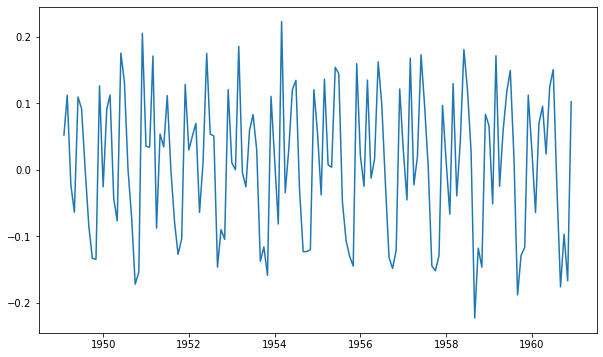

In [110]:
#Differentiating the time series by 1 
dataShifted = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(dataShifted)

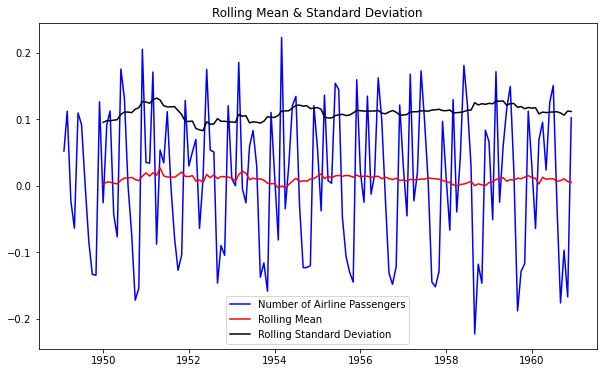

In [111]:
#Our data looks stationary but let's run the test in the next cell
dataShifted.dropna(inplace=True)
plot_stationarity(dataShifted)

In [112]:
#Our time series is basically stationary. 
#We reject the null hypothesis that the data is non-stationary
test_stationarity(dataShifted)

Test Statistic                     -2.717131
p-value                             0.071121
#Lags Used                                14
Number of Observations Used              128
Maximized Information Criterion   -440.35847
Critical Value (1%)                -3.482501
Critical Value (5%)                -2.884398
Critical Value (10%)                -2.57896
dtype: object

In [113]:
kpss_test(dataShifted) #We do not reject the null that the data is non-stationary

Test Statistic           0.038304
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

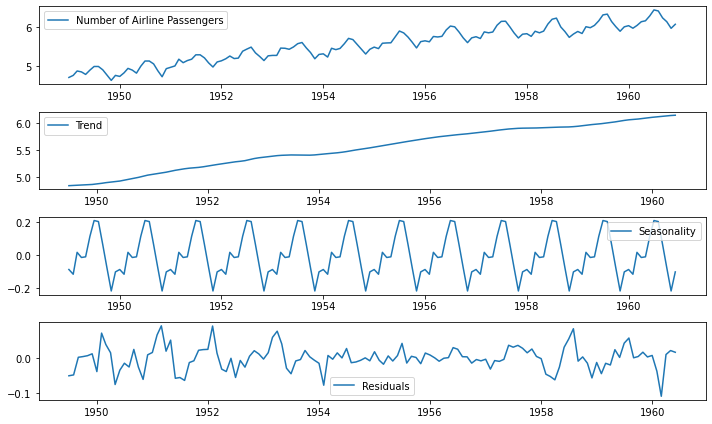

In [114]:
decomposition = seasonal_decompose(indexedDataset_logScale)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label= 'Number of Airline Passengers')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [115]:
decomposedLogData = residual 
decomposedLogData.dropna(inplace=True) 

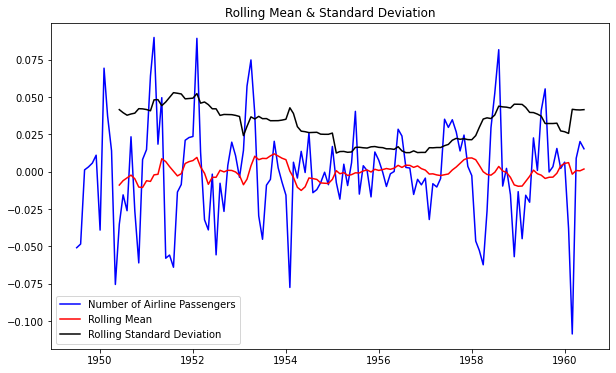

In [116]:
# High variation in residual between 1950 - 1954 & 1957 - 1960
# Lower variability between 1954 - 1957 which is interesting.
plot_stationarity(decomposedLogData)

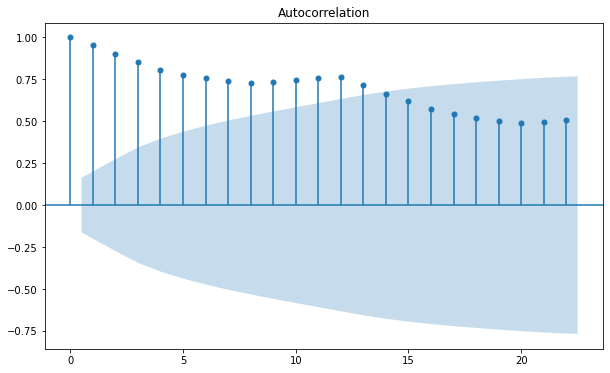

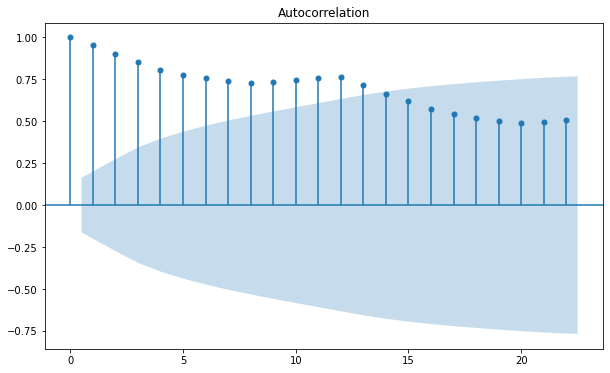

In [117]:
plot_acf(indexedDataset_logScale)
#Blue area is confidence interval
#There is seasonality in the data
# The order of the Moving Average part can be inferred from the ACF plot (q or Q)
# The blue area is the confidence interval
# y-axis is the autocorrelation level
# x-axis Lags
# Autocorrelation is high at least around .5
# This is an ACF plot with 20 lags.

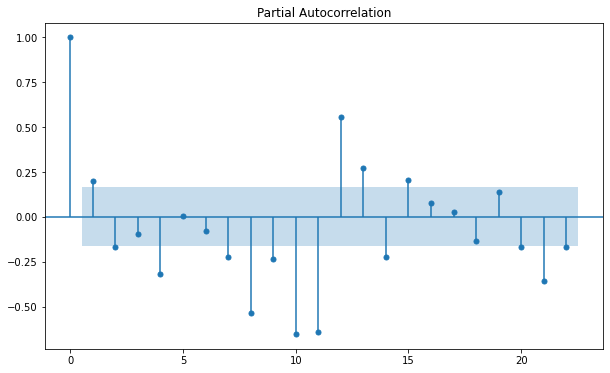

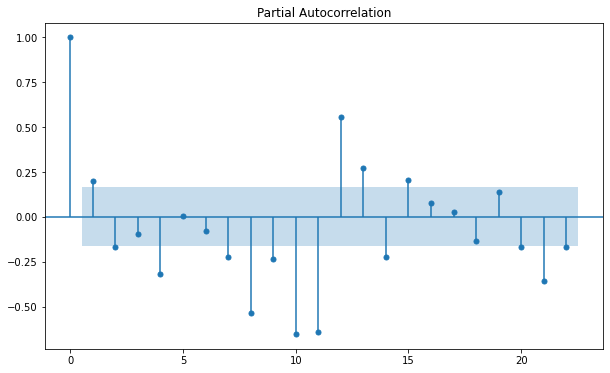

In [118]:
#Partial Auto-Correlation Function (PACF)
d = indexedDataset_logScale.diff().dropna()
plot_pacf(d)
#Partial Auto-Correlation is the relationship between a lagged value and its succeeding value.
#Here there is both positive and negative Autocorrelation 
# The order of AR can be inferred from this plot

#### SARIMA
##### The SARIMA model works much better on this data

In [71]:
def SARIMA(data, order, seasonal_order, steps):
    # fit model
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    # make prediction
    yhat = model_fit.forecast(steps=steps)
    return yhat

In [72]:
preds = SARIMA(indexedDataset, (2,1,1), (2,2,2,12), 20)

In [73]:
predictions = pd.Series(indexedDataset['#Passengers'], 
                           index = indexedDataset.index)
predictions = predictions.add(preds, fill_value = 0)

Text(1950-01-01 00:00:00, 600, 'RMSE is 28.423630480575586')

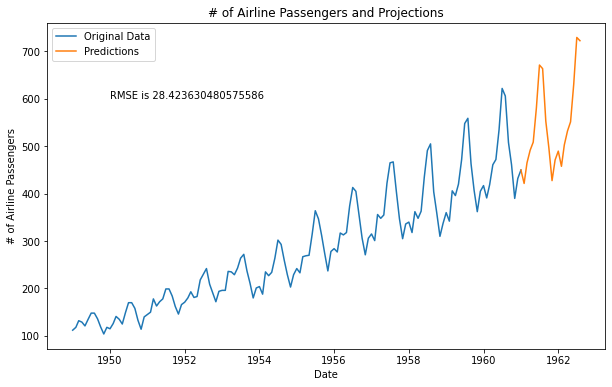

In [120]:
plt.plot(predictions[:-19], label='Original Data')
plt.plot(predictions[-20:], label='Predictions') #That's a huge improvement!
plt.legend()
plt.xlabel('Date')
plt.ylabel('# of Airline Passengers')
plt.title('# of Airline Passengers and Projections')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), 600))

#### SARIMA Grid Search Coding Mental Challenge
The ARIMA has a grid search for the best (p, d, q) values. We could do the same thing with SARIMA to find the best combination of parameters. I have done this with other statistical methods including logistic regression in Python using multithreading for speed. We would also need to use combinatorics to populate all the possible combinations without repetition where order matters: permutations. I have the code to populate all the permutations:

```
from itertools import permutations
output = []
for c in permutations([i for i in range(6)], 3):
    output.append(c)

```

The next step would be to construct a for loop and submit all of them to the 'submit' method and use maximum likelihood estimation method, conditional sum of squares or another method to rate the models with varying parameters to choose the best one.

For example, here is some similar code that I wrote for fun to choose the best parameters for a logistic regression model. I was inspired by the grid search functionality in sklearn. Using multithreading, I was able to create my own grid search that ran much faster than sklearn's grid search function.

```

def thread_training(X_train, y_train, X_test, y_test, solver, C):
    threads = min(100, len(solver)*len(C)*2)
    output = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        for s in solver:
            for c in C:
                if s in ['newton-cg','lbfgs', 'sag']:
                    output[executor.submit(run_regression, X_train, y_train, solver=s, penalty='l2', C=c)] = (s, 'l2', c)
                elif s =='saga':
                    for p in ['l1', 'l2', 'elasticnet']:
                        if p == 'elasticnet':
                            for l1 in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
                                output[executor.submit(run_regression, X_train, y_train, solver=s, penalty=p, C=c, l1_ratio=l1)] =(s,p,c,l1)
                        else:
                            output[executor.submit(run_regression, X_train, y_train, solver=s, penalty=p, C=c)] = (s, p, c)
                else:
                    for p in ['l1', 'l2']:
                        output[executor.submit(run_regression, X_train, y_train, solver=s, penalty=p, C=c)] = (s, p, c)
    return output

def thread_save(results, X_train, y_train, X_test, y_test):
    threads = min(100, len(results))
    output = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        for each in results:
            output[each] = executor.submit(save_results, each, X_train, y_train, X_test, y_test)
    return output

def run_regression(X_train, y_train, solver, penalty, C, l1_ratio=None):

    reg = LogisticRegression(C=C, penalty=penalty, 
                             random_state=0, solver=solver, 
                             max_iter=100,l1_ratio=l1_ratio).fit(X_train, y_train)
    return reg

def save_results(results, X_train, y_train, X_test, y_test):
        y_pred = results.result().predict(X_test)
        tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
        return {'penalty':results.result().penalty, 
                           'solver':results.result().solver, 
                           'train_score':results.result().score(X_train, y_train), 
                           'test_score': results.result().score(X_test, y_test),
                           'f1_score': f1_score(y_test, y_pred),
                           'true_positive_rate':tp/(tp + fp),
                           'true_negative_rate':tn/(tn+fn),
                           'l1_ratio':results.result().l1_ratio,
                           'C': results.result().C
                          }


```

#### ARIMA With Log Scale Data

In [121]:
# Auto ARIMA takes into account the AIC and BIC values generated 
#     to determine the best combination of parameters: 
#     AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion).
# AIC uses the number of independent variables and 
#     the maximum likelihood estimate of the model to determine best fit.
#      The best-fit model is the one that explains the greatest amount of variation 
#      using the fewest possible independent variables.
# BIC has a larger penalty for more independent variables and involves
#      the number of observations in the formula
results = auto_arima(indexedDataset_logScale, trace=True, suppress_warnings=True)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-262.595, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-231.565, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-235.386, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-237.507, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-232.439, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-267.212, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-241.608, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-237.605, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-269.459, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-236.952, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-248.753, Time=0.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-269.823, Time=0.65 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-275.555, Time=1.06 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(4, 1, 3)   Log Likelihood                 151.331
Date:                Thu, 21 Apr 2022   AIC                           -284.662
Time:                        23:23:26   BIC                           -257.997
Sample:                             0   HQIC                          -273.827
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0122      0.002      6.597      0.000       0.009       0.016
ar.L1          0.2925      0.108      2.699      0.007       0.080       0.505
ar.L2         -0.3819      0.116     -3.279      0.001      -0.610      -0.154
ar.L3          0.4781      0.083      5.789      0.000       0.316       0.640
ar.L4         -0.5975      0.109     -5.479      0.000      -0.811      -0.384
ma.L1         -0.2656      0.168     -1.577      0.115      -0.596       0.065
ma.L2          0.0506      0.162      0.312      0.755      -0.267       0.368
ma.L3         -0.6967      0.155     -4.482      0.000      -1.001      -0.392
sigma2         0.0068      0.001      5.478      0.000       0.004       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.92
Prob(Q):                              0.93   Prob(JB):                         0.38
Heteroskedasticity (H):               1.23   Skew:                             0.10
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
model = ARIMA(indexedDataset_logScale, order = (4 , 1, 3)) #ARIMA
results = model.fit()
# linear function of the differenced observations and residual errors at prior time steps.
# Our model must have a trend as we can see from graphs. 
# Suitable if there are no seasonal components which there probably are in this data. 

In [123]:
error = results.fittedvalues - indexedDataset_logScale['#Passengers']
errorsq = error**2
rss= errorsq.sum()
rss
#can also use from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(results.fittedvalues, indexedDataset_logScale))
print(rss, rmse)

23.289053764788818 0.4021561140070553


Text(0.5, 1.0, 'Log Scale Data & Fitted Values')

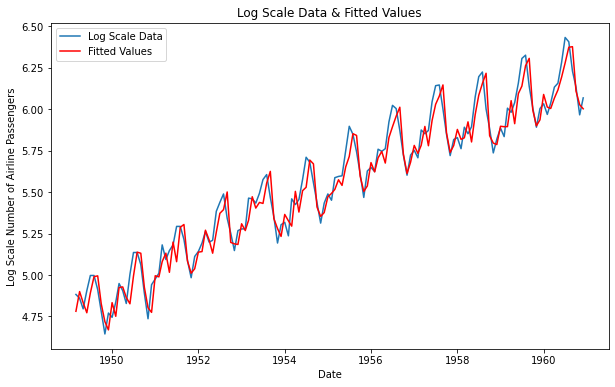

In [126]:
plt.plot(indexedDataset_logScale[2:], label='Log Scale Data')
plt.plot(results.fittedvalues[2:], label='Fitted Values',color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Scale Number of Airline Passengers')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), 500))
plt.title('Log Scale Data & Fitted Values')

In [127]:
results.summary()
#Jarque-Bera test is a test for normality. 
# A goodness-of-fit test of whether sample data have the skewness and kurtosis 
# matching a normal distribution.
# A normal distribution has a skew of zero and a kurtosis of three.
# The skew is close to zero but the kurtosis is a little less than three.
# Prob(JB) = .57 means that we cannot reject the null the data is normally distributed.
# Ljung-Box: Test to see if any of a group of autocorrelations of a time series 
#            are different from zero.
# With a Prob(Q) of .4 we say that we cannot reject the null that there is NOT a lack of fit. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 3)   Log Likelihood                 149.798
Date:                Thu, 21 Apr 2022   AIC                           -283.595
Time:                        23:24:36   BIC                           -259.893
Sample:                    01-01-1949   HQIC                          -273.964
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1720      0.130      1.324      0.186      -0.083       0.427
ar.L2         -0.4050      0.106     -3.816      0.000      -0.613      -0.197
ar.L3          0.5963      0.105      5.679      0.000       0.390       0.802
ar.L4         -0.5420      0.120     -4.499      0.000      -0.778      -0.306
ma.L1          0.0763      0.119      0.643      0.520      -0.156       0.309
ma.L2          0.2704      0.121      2.227      0.026       0.032       0.508
ma.L3         -0.7867      0.152     -5.169      0.000      -1.085      -0.488
sigma2         0.0069      0.001      5.354      0.000       0.004       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.40   Prob(JB):                         0.57
Heteroskedasticity (H):               1.14   Skew:                            -0.20
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [128]:
indexedDataset_logScale[2:].head()

,#Passengers
Month,
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
1949-06-01,4.905275
1949-07-01,4.997212


Text(0.5, 1.0, 'Fitted versus Original Values')

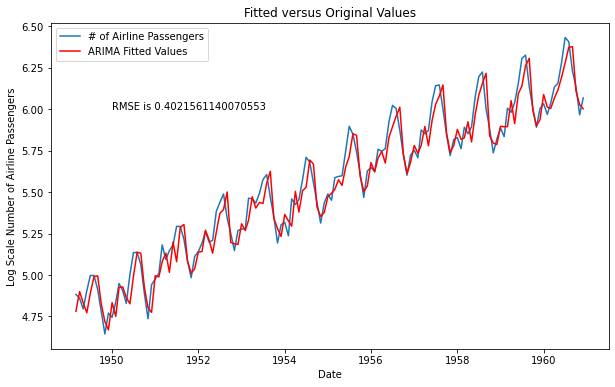

In [130]:
plt.plot(indexedDataset_logScale[2:], label='# of Airline Passengers')
plt.plot(results.fittedvalues[2:], color='red', label='ARIMA Fitted Values')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Log Scale Number of Airline Passengers')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), 6))
plt.title('Fitted versus Original Values')

In [131]:
preds = results.forecast(steps=20)
preds

1961-01-01    6.161459
1961-02-01    6.154707
1961-03-01    6.215827
1961-04-01    6.229114
1961-05-01    6.152194
1961-06-01    6.173685
1961-07-01    6.183327
1961-08-01    6.123217
1961-09-01    6.163476
1961-10-01    6.188847
1961-11-01    6.135840
1961-12-01    6.173031
1962-01-01    6.194203
1962-02-01    6.137427
1962-03-01    6.169990
1962-04-01    6.191053
1962-05-01    6.136159
1962-06-01    6.168375
1962-07-01    6.191058
1962-08-01    6.137766
Freq: MS, Name: predicted_mean, dtype: float64

In [132]:
#how to append one series on another
predictionsLog = pd.Series(indexedDataset_logScale['#Passengers'], index = indexedDataset_logScale.index)
predictionsLog = predictionsLog.add(preds, fill_value = 0)
predictionsLog

1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1962-04-01    6.191053
1962-05-01    6.136159
1962-06-01    6.168375
1962-07-01    6.191058
1962-08-01    6.137766
Length: 164, dtype: float64

In [133]:
predictions = np.exp(predictionsLog)
predictions #The data is now in its original form with predictions appended

1949-01-01    112.000000
1949-02-01    118.000000
1949-03-01    132.000000
1949-04-01    129.000000
1949-05-01    121.000000
                 ...    
1962-04-01    488.359874
1962-05-01    462.274450
1962-06-01    477.409570
1962-07-01    488.362333
1962-08-01    463.017826
Length: 164, dtype: float64

Text(1950-01-01 00:00:00, 500, 'RMSE is 0.4021561140070553')

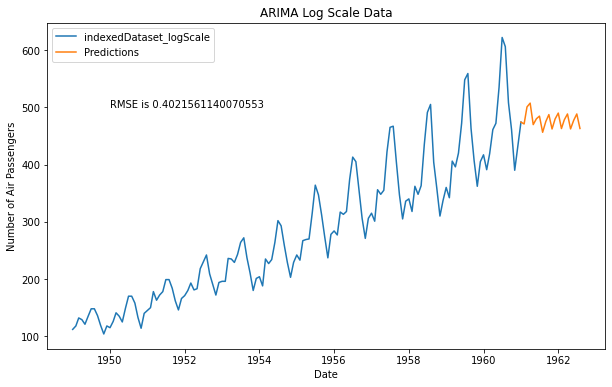

In [134]:
# Due to seasonality. SARIMA would be a better model
plt.plot(predictions[:-19], label='indexedDataset_logScale')
plt.plot(predictions[-20:], label='Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Air Passengers')
plt.title('ARIMA Log Scale Data')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), 500))

#### ARMA with log scale minus moving average

In [135]:
results = auto_arima(LogScaleMinusMovingAverage, trace=True, suppress_warnings=True)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-277.447, Time=1.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-152.169, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-233.989, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-246.526, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-133.698, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-252.154, Time=0.34 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-279.238, Time=0.67 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-254.090, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-260.142, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-277.308, Time=2.21 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-261.472, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-285.263, Time=1.27 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-282.141, Time=0.91 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-267.794, Time=0.74 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:               SARIMAX(3, 0, 2)   Log Likelihood                 149.632
Date:                Thu, 21 Apr 2022   AIC                           -285.263
Time:                        23:26:05   BIC                           -265.031
Sample:                             0   HQIC                          -277.042
                                - 133                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0258      0.006      4.164      0.000       0.014       0.038
ar.L1          0.7863      0.155      5.081      0.000       0.483       1.090
ar.L2          0.2893      0.204      1.419      0.156      -0.110       0.689
ar.L3         -0.5326      0.129     -4.139      0.000      -0.785      -0.280
ma.L1          0.0982      0.121      0.814      0.416      -0.138       0.335
ma.L2         -0.7531      0.089     -8.496      0.000      -0.927      -0.579
sigma2         0.0061      0.001      5.762      0.000       0.004       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 4.41
Prob(Q):                              0.58   Prob(JB):                         0.11
Heteroskedasticity (H):               1.06   Skew:                             0.08
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
model = ARIMA(LogScaleMinusMovingAverage, order = (3 , 0, 2)) #ARMA with no integration.
results = model.fit()
#ARMA: linear function of the observations and residual errors at prior time steps.
#Suitable for data without trend or seasonal components.
# Subtracting the moving average changed the model choice to ARMA

In [137]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  133
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 149.632
Date:                Thu, 21 Apr 2022   AIC                           -285.265
Time:                        23:26:06   BIC                           -265.032
Sample:                    12-01-1949   HQIC                          -277.043
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0565      0.005     10.363      0.000       0.046       0.067
ar.L1          0.7863      0.154      5.101      0.000       0.484       1.088
ar.L2          0.2886      0.203      1.424      0.155      -0.109       0.686
ar.L3         -0.5308      0.128     -4.147      0.000      -0.782      -0.280
ma.L1          0.0980      0.120      0.818      0.414      -0.137       0.333
ma.L2         -0.7543      0.088     -8.564      0.000      -0.927      -0.582
sigma2         0.0061      0.001      5.764      0.000       0.004       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 4.42
Prob(Q):                              0.59   Prob(JB):                         0.11
Heteroskedasticity (H):               1.07   Skew:                             0.08
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
results.fittedvalues

Month
1949-12-01    0.056477
1950-01-01   -0.026331
1950-02-01   -0.035629
1950-03-01    0.064324
1950-04-01    0.137993
                ...   
1960-08-01    0.246982
1960-09-01    0.169329
1960-10-01   -0.016472
1960-11-01   -0.048708
1960-12-01   -0.191300
Length: 133, dtype: float64

In [139]:
rmse = sqrt(mean_squared_error(results.fittedvalues, LogScaleMinusMovingAverage))
rmse

0.07859759654471396

In [140]:
LogScaleMinusMovingAverage.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


Text(0.5, 1.0, 'ARMA Log Scale Minus Moving Average: Fitted versus Original Values')

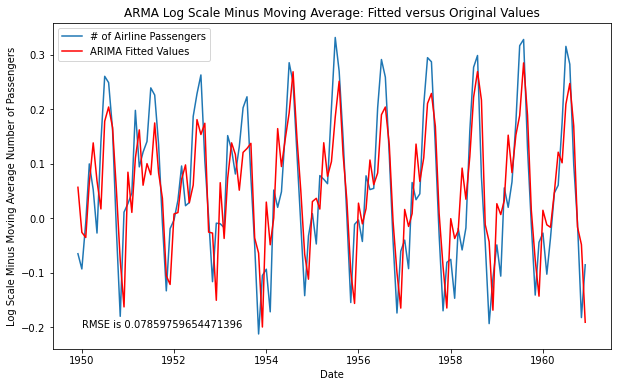

In [141]:
plt.plot(LogScaleMinusMovingAverage, label='# of Airline Passengers')
plt.plot(results.fittedvalues, color='red', label='ARIMA Fitted Values')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Log Scale Minus Moving Average Number of Passengers')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), -.2))
plt.title('ARMA Log Scale Minus Moving Average: Fitted versus Original Values')

In [142]:
preds = results.forecast(steps=20)
preds #Preds from 1961 - 1962

1961-01-01    0.021880
1961-02-01    0.035590
1961-03-01    0.105589
1961-04-01    0.107430
1961-05-01    0.121801
1961-06-01    0.096473
1961-07-01    0.079729
1961-08-01    0.051625
1961-09-01    0.038141
1961-10-01    0.028317
1961-11-01    0.031619
1961-12-01    0.038538
1962-01-01    0.050147
1962-02-01    0.059518
1962-03-01    0.066564
1962-04-01    0.068646
1962-05-01    0.067341
1962-06-01    0.063177
1962-07-01    0.058420
1962-08-01    0.054171
Freq: MS, Name: predicted_mean, dtype: float64

In [143]:
#how to append one series on another
predictionsLog = pd.Series(LogScaleMinusMovingAverage['#Passengers'], 
                           index = LogScaleMinusMovingAverage.index)
predictionsLog = predictionsLog.add(preds, fill_value = 0)
predDf = pd.DataFrame(predictionsLog, columns = ['preds'])

In [144]:
predDf['movingAverage'] = movingAverage

In [145]:
predDf['movingAverage'].fillna(method='ffill', inplace=True) 
#Forward filling the last movingAverage for addition into predictions

In [146]:
predDf.fillna(method='ffill', inplace=True) 
#Forward filling the last movingAverage for addition into predictions

In [147]:
predDf['undifferencing'] = predDf['preds'] + predDf['movingAverage']
predDf['expon'] = np.exp(predDf['undifferencing'])
predDf #The data is now in its original form with predictions appended

,preds,movingAverage,undifferencing,expon
1949-12-01,-0.065494,4.836178,4.770685,118.000000
1950-01-01,-0.093449,4.838381,4.744932,115.000000
1950-02-01,-0.007566,4.843848,4.836282,126.000000
1950-03-01,0.099416,4.849344,4.948760,141.000000
1950-04-01,0.052142,4.853133,4.905275,135.000000
...,...,...,...,...
1962-04-01,0.068646,6.154215,6.222861,504.143417
1962-05-01,0.067341,6.154215,6.221556,503.486264
1962-06-01,0.063177,6.154215,6.217392,501.393718
1962-07-01,0.058420,6.154215,6.212635,499.014598


Text(1950-01-01 00:00:00, 500, 'RMSE is 0.07859759654471396')

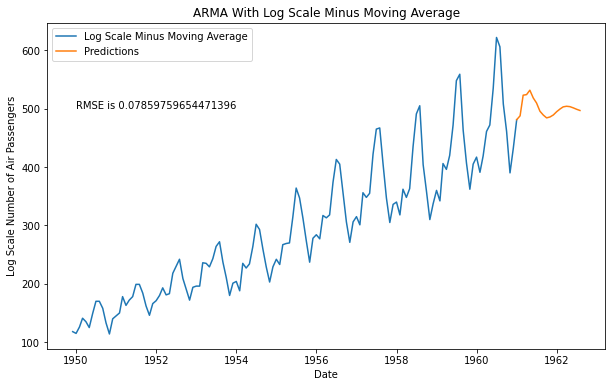

In [148]:
#plt.plot(indexedDataset)
plt.plot(predDf['expon'][:-19], label='Log Scale Minus Moving Average')
plt.plot(predDf['expon'][-20:], label='Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Scale Number of Air Passengers')
plt.title('ARMA With Log Scale Minus Moving Average')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), 500))

#### ARIMA With Original Data

In [149]:
results = auto_arima(indexedDataset, trace=True, suppress_warnings=True)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1415.278, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1403.473, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1398.827, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1413.909, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1396.121, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1398.386, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1397.975, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1394.683, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1397.258, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1401.852, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1378.338, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1396.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(4, 1, 3)   Log Likelihood                -674.913
Date:                Thu, 21 Apr 2022   AIC                           1365.825
Time:                        23:27:35   BIC                           1389.528
Sample:                             0   HQIC                          1375.457
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5582      0.117     -4.782      0.000      -0.787      -0.329
ar.L2          0.4935      0.113      4.375      0.000       0.272       0.715
ar.L3          0.1238      0.128      0.970      0.332      -0.126       0.374
ar.L4         -0.5213      0.085     -6.136      0.000      -0.688      -0.355
ma.L1          0.9069      0.094      9.657      0.000       0.723       1.091
ma.L2         -0.5590      0.145     -3.866      0.000      -0.842      -0.276
ma.L3         -0.7385      0.109     -6.778      0.000      -0.952      -0.525
sigma2       724.1724     85.616      8.458      0.000     556.369     891.976
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                14.59
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               5.66   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [150]:
model = ARIMA(indexedDataset, order = (4 , 1, 3)) #ARIMA model
results = model.fit()
#Our data has a trend and looks like seasonal components as well.
# SARIMA may be best

In [151]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -674.913
Date:                Thu, 21 Apr 2022   AIC                           1365.825
Time:                        23:27:35   BIC                           1389.528
Sample:                    01-01-1949   HQIC                          1375.457
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5582      0.117     -4.782      0.000      -0.787      -0.329
ar.L2          0.4935      0.113      4.375      0.000       0.272       0.715
ar.L3          0.1238      0.128      0.970      0.332      -0.126       0.374
ar.L4         -0.5213      0.085     -6.136      0.000      -0.688      -0.355
ma.L1          0.9069      0.094      9.657      0.000       0.723       1.091
ma.L2         -0.5590      0.145     -3.866      0.000      -0.842      -0.276
ma.L3         -0.7385      0.109     -6.778      0.000      -0.952      -0.525
sigma2       724.1724     85.616      8.458      0.000     556.369     891.976
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                14.59
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               5.66   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [152]:
results.fittedvalues

Month
1949-01-01      0.000000
1949-02-01    112.039908
1949-03-01    119.858646
1949-04-01    136.007001
1949-05-01    124.632246
                 ...    
1960-08-01    611.964129
1960-09-01    549.230184
1960-10-01    451.474550
1960-11-01    427.629261
1960-12-01    393.635834
Length: 144, dtype: float64

In [153]:
rmse = sqrt(mean_squared_error(results.fittedvalues, indexedDataset))
rmse

28.423630480575586

In [154]:
indexedDataset.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0.5, 1.0, 'ARIMA Original Data: Fitted versus Original Values')

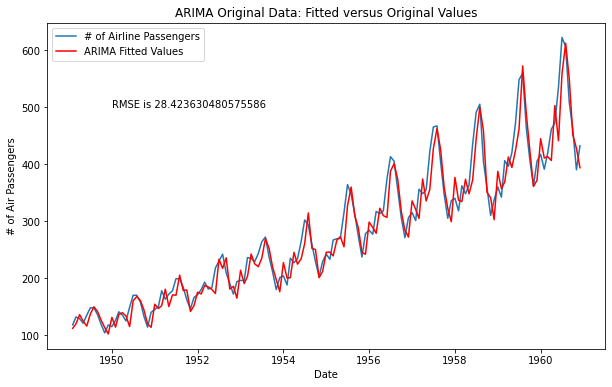

In [156]:
plt.plot(indexedDataset[1:], label='# of Airline Passengers')
plt.plot(results.fittedvalues[1:], color='red', label='ARIMA Fitted Values')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('# of Air Passengers')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), 500))
plt.title('ARIMA Original Data: Fitted versus Original Values')

In [157]:
preds = results.forecast(steps=20)
preds #Preds from 1961 - 1962

1961-01-01    467.573802
1961-02-01    490.494557
1961-03-01    509.136936
1961-04-01    492.554763
1961-05-01    495.305967
1961-06-01    475.947804
1961-07-01    476.339839
1961-08-01    475.552139
1961-09-01    472.353824
1961-10-01    483.889673
1961-11-01    475.570194
1961-12-01    485.921540
1962-01-01    479.133632
1962-02-01    480.987441
1962-03-01    482.221411
1962-04-01    476.211040
1962-05-01    483.942827
1962-06-01    475.847372
1962-07-01    482.794271
1962-08-01    479.011975
Freq: MS, Name: predicted_mean, dtype: float64

In [158]:
data = pd.Series(indexedDataset['#Passengers'], index = indexedDataset.index)
predictions = data.add(preds, fill_value = 0)
predictions

1949-01-01    112.000000
1949-02-01    118.000000
1949-03-01    132.000000
1949-04-01    129.000000
1949-05-01    121.000000
                 ...    
1962-04-01    476.211040
1962-05-01    483.942827
1962-06-01    475.847372
1962-07-01    482.794271
1962-08-01    479.011975
Length: 164, dtype: float64

Text(1950-01-01 00:00:00, 500, 'RMSE is 28.423630480575586')

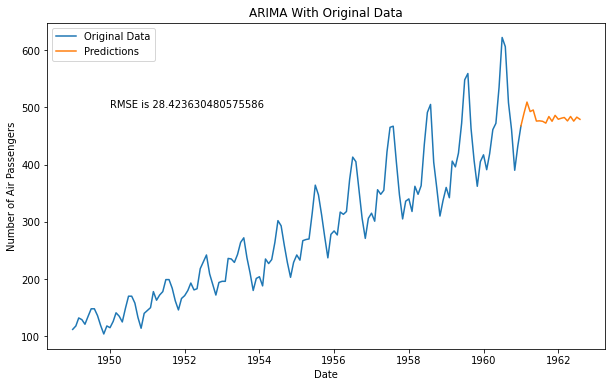

In [160]:
plt.plot(predictions[:-19], label='Original Data')
plt.plot(predictions[-20:], label='Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Air Passengers')
plt.title('ARIMA With Original Data')
plt.annotate(f'RMSE is {rmse}', xy =(datetime.strptime("1950-01-01", "%Y-%m-%d"), 500))

#### Seasonal Differencing

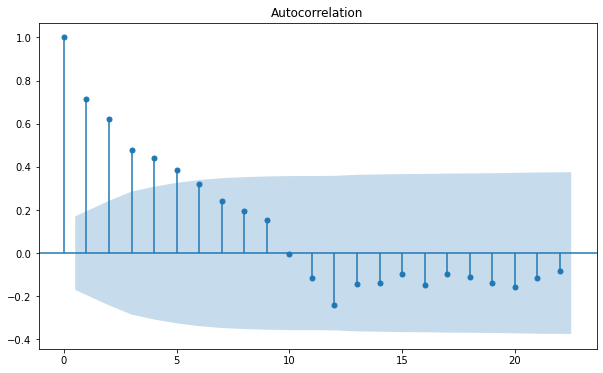

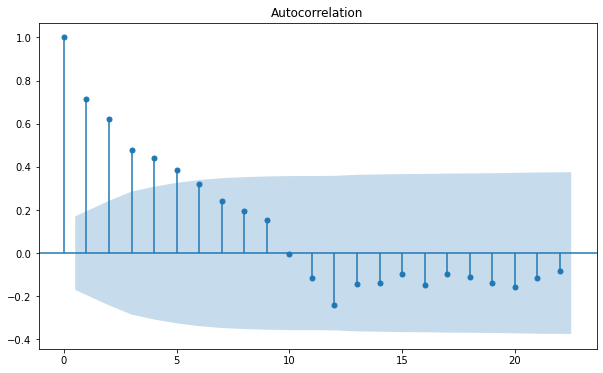

In [161]:
d = indexedDataset_logScale.diff(12).dropna()
plot_acf(d)

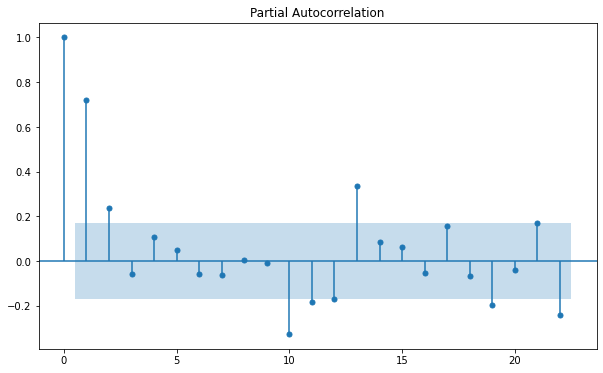

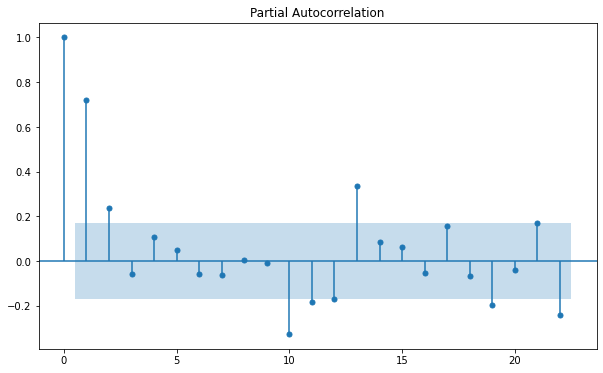

In [162]:
d = indexedDataset_logScale.diff(12).dropna()
plot_pacf(d)